In [238]:
import mne
import cv2
import matplotlib.pyplot as plt
import numpy
from MNE_Pipeline import MNE_Repo_Mat as MP
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
from matplotlib import gridspec
from matplotlib import cm
%matplotlib inline
SMALL_SIZE = 12
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.style.use('ggplot')

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [229]:
mp = MP()
info = mp.construct_info()

bts_erp = pickle.load(open('bootstrap_erps_RT_rate_50/N1', 'rb'))

bts_subs = pd.read_csv('data_bp_rt_50/subject_RT_50.csv', header=None)
bts_bp = pd.read_csv('data_bp_rt_50/data_bp_RT_50.csv', header=None)
bts_lbl = pd.read_csv('data_bp_rt_50/labels_RT_50.csv', header=None, dtype=int)

bts_data = bts_bp.copy()
bts_data.insert(0, 'subs', bts_subs)
bts_data.insert(1, 'rt_class', bts_lbl)

mapping = {0: 'slow', 1: 'fast', 3: 'med'}

bts_data.replace({'rt_class': mapping}, inplace=True)
print(bts_data.head())
sample_bp = bts_data.values[1,2:194]
sample_erp = bts_erp['1'][0][np.newaxis, ...]

/home/kam/anaconda3/envs/mne/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/home/kam/anaconda3/envs/mne/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/kam/decode_cp_RT_cnn/data_generation/MNE_Pipeline.py:57: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please 

  subs rt_class         0         1         2         3         4         5  \
0   N1     slow  0.001329  0.000869  0.002517  0.000712  0.000987  0.020380   
1   N1     fast  0.003833  0.001140  0.003245  0.000800  0.001510  0.011468   
2   N1     fast  0.002691  0.000944  0.003069  0.000821  0.001980  0.009210   
3   N1     fast  0.005190  0.001826  0.007556  0.000895  0.003006  0.022112   
4   N1     fast  0.002968  0.000623  0.005179  0.000727  0.001997  0.016826   

          6         7  ...       182       183       184       185       186  \
0  0.000523  0.000557  ...  0.000038  0.000020  0.000019  0.000031  0.000027   
1  0.000193  0.000233  ...  0.000016  0.000011  0.000012  0.000023  0.000017   
2  0.000526  0.000444  ...  0.000017  0.000011  0.000008  0.000024  0.000011   
3  0.000270  0.000537  ...  0.000029  0.000017  0.000015  0.000042  0.000016   
4  0.000936  0.000693  ...  0.000015  0.000012  0.000011  0.000023  0.000012   

        187       188       189       190   

In [218]:
sample_mne_erp = mne.EpochsArray(sample_erp, info=info)

psd_alpha, freq_alpha = mne.time_frequency.psd_welch(sample_mne_erp, 8, 15, n_fft=500, n_per_seg=500, verbose=False)
psd_beta, freq_beta = mne.time_frequency.psd_welch(sample_mne_erp, 16, 31, n_fft=500, n_per_seg=500, verbose=False)
psd_gamma, freq_gamma = mne.time_frequency.psd_welch(sample_mne_erp, 32, 60, n_fft=500, n_per_seg=500, verbose=False)

band_pow_alpha = np.average(psd_alpha, axis=2).flatten()
band_pow_beta = np.average(psd_beta, axis=2).flatten()
band_pow_gamma = np.average(psd_gamma, axis=2).flatten()

bps = [band_pow_alpha, band_pow_beta, band_pow_gamma]
psds = np.hstack((psd_alpha[0,:,:], psd_beta[0,:,:], psd_gamma[0,:,:]))
freqs = np.hstack((freq_alpha, freq_beta, freq_gamma))

1 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [148]:
psds.max()

0.12187364958430708

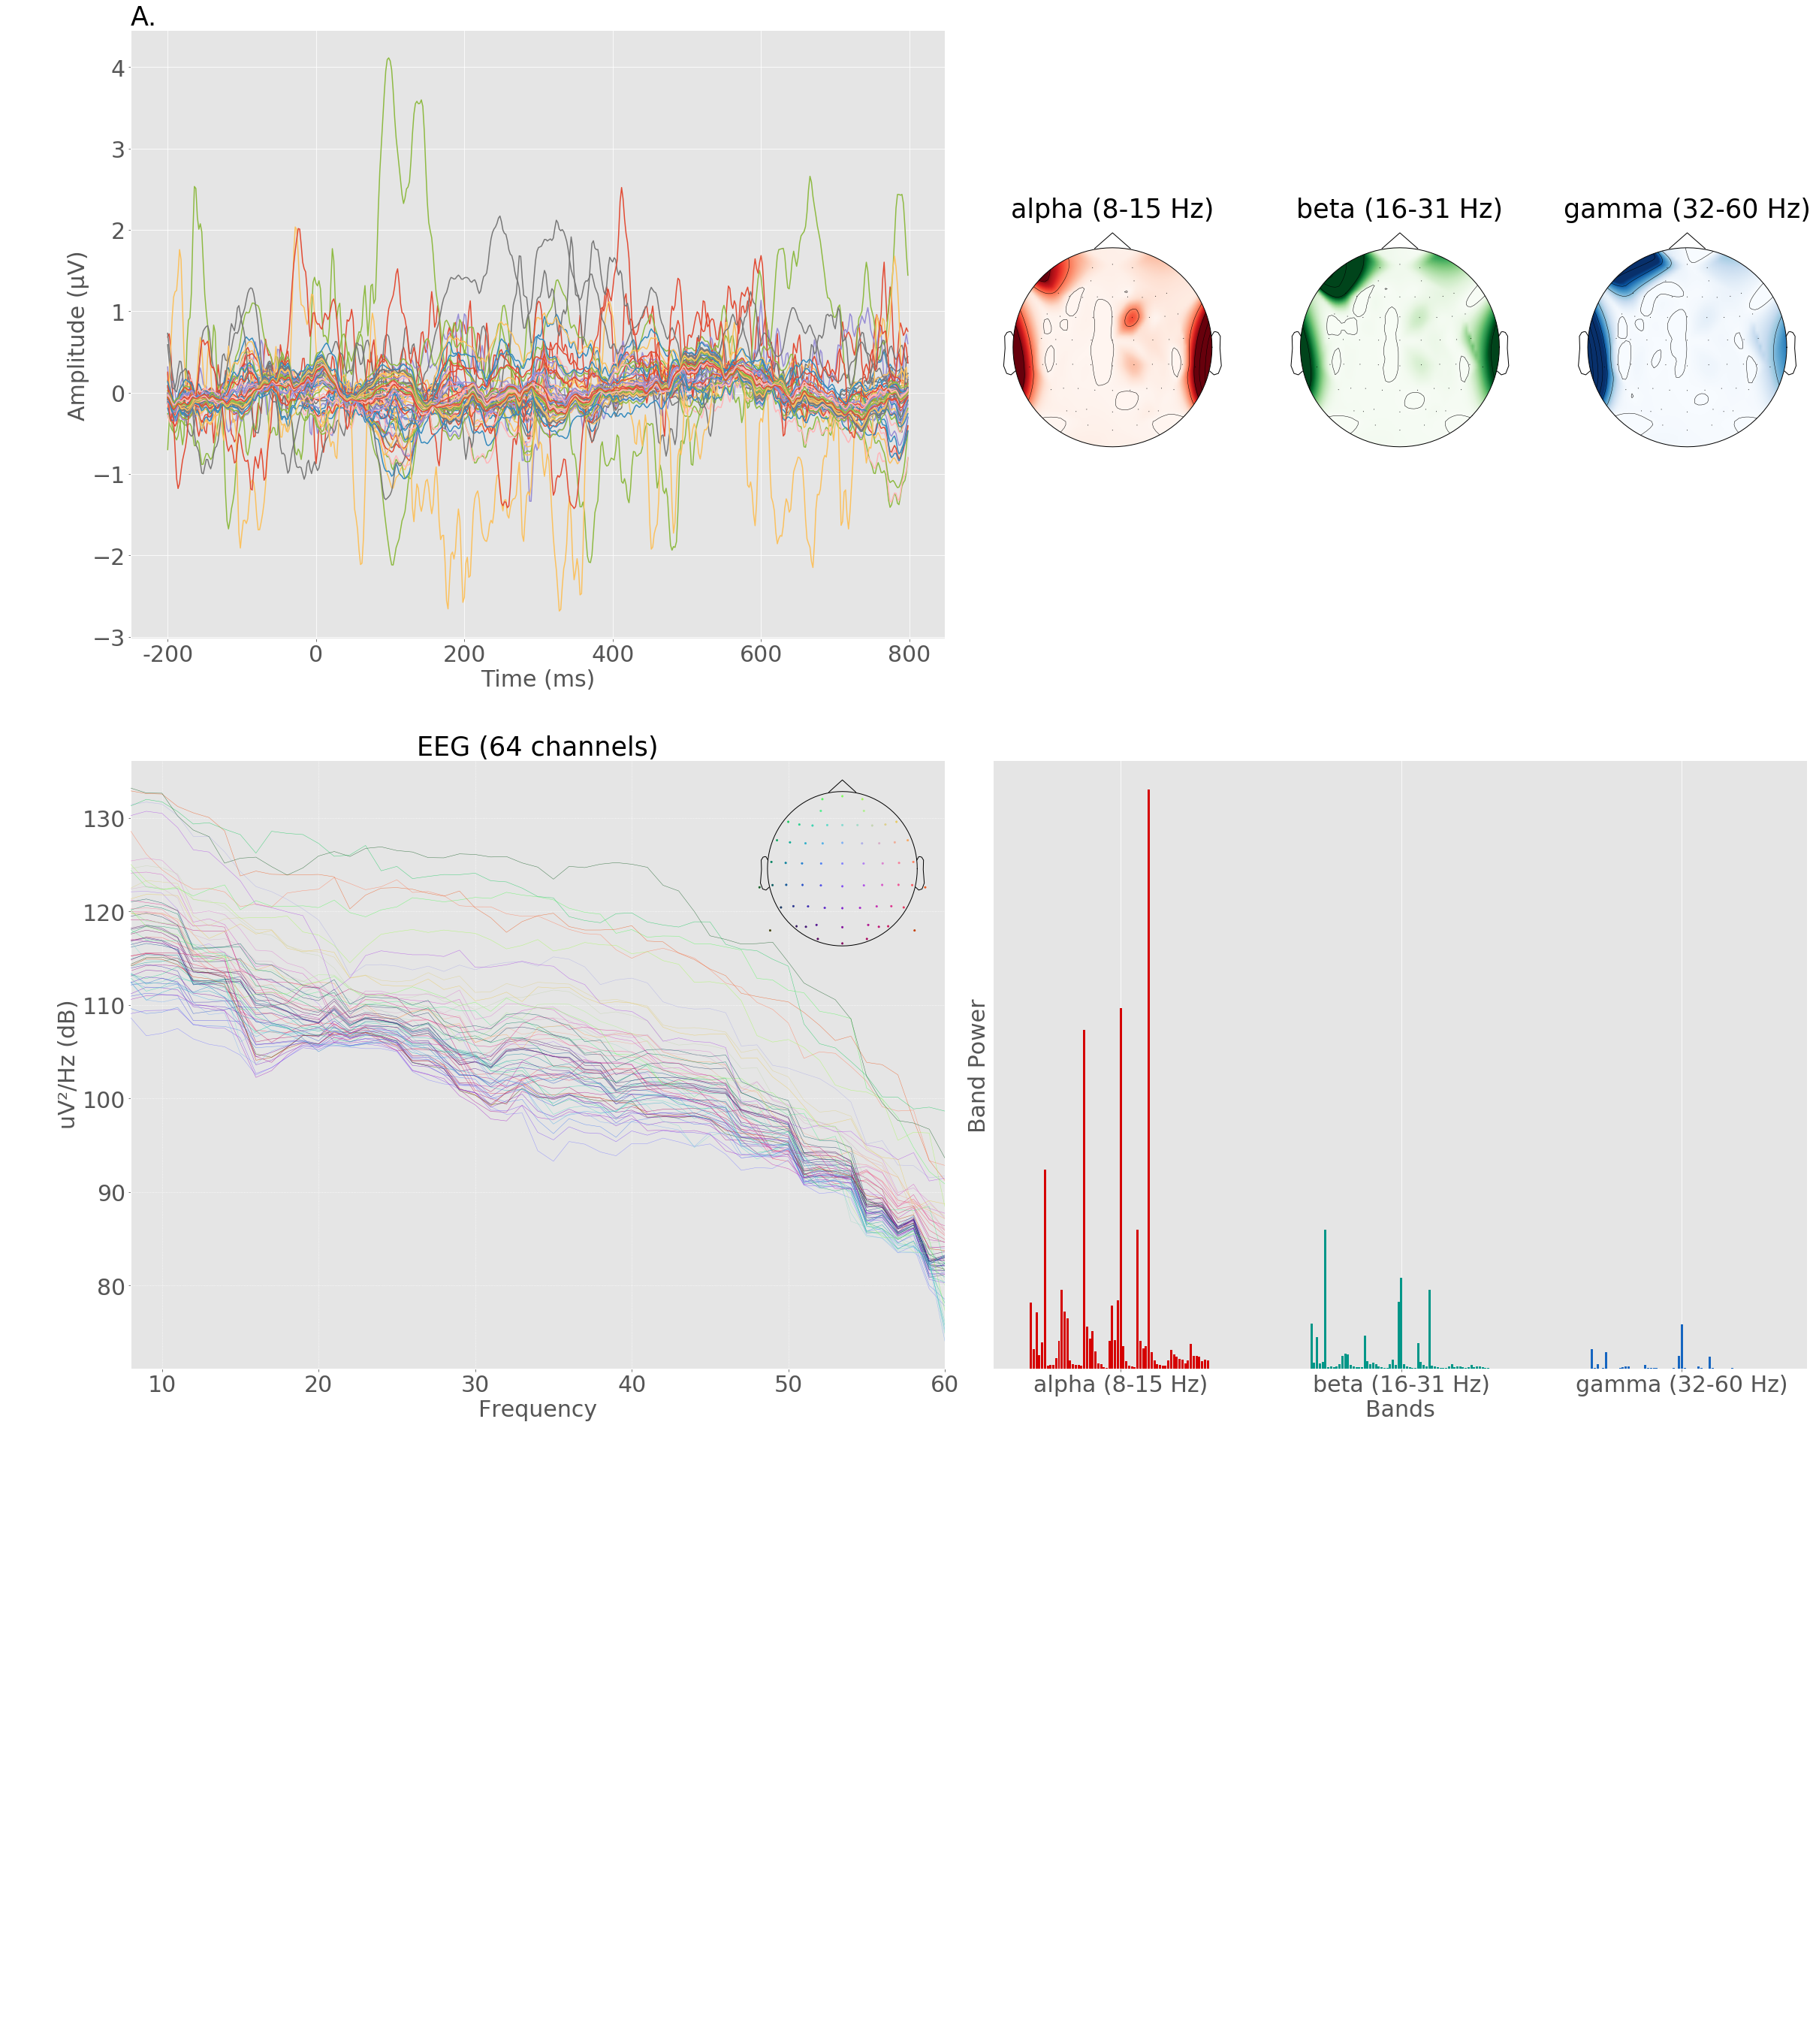

<Figure size 432x288 with 0 Axes>

In [292]:
gs = gridspec.GridSpec(nrows=2, ncols=6, width_ratios=[2,2,2,2,2,2])

fig = plt.figure(figsize=(40,30))

plt.subplot(gs[0,0:3])
plt.title('A.', loc='left')
plt.plot(sample_erp[0].transpose())
plt.ylabel('Amplitude (μV)')
plt.xlabel('Time (ms)')
plt.xticks(np.arange(0,501,100),labels=[-200,0,200,400,600,800])

plt.subplot(gs[1,3:6])
colors = ["#d50000", "#009688", "#1565C0"]
channels = np.arange(0,64)
for i, bp in enumerate(bps):
    plt.bar(channels, bp, color=colors[i])    
    channels = channels + 100
bands = ['alpha (8-15 Hz)', 'beta (16-31 Hz)', 'gamma (32-60 Hz)']
plt.xticks([32, 132, 232], labels=bands)
plt.yticks([])
plt.xlabel('Bands')
plt.ylabel('Band Power') 

j = 3
cmaps = ['Reds', 'Greens', 'Blues']
for i, bp in enumerate(bps): 
    ax = plt.subplot(gs[0,j])
    ax.set_title(bands[i])
    mne.viz.plot_topomap(bp, info, cmap=cmaps[i], axes=ax, show=False)
    j += 1

ax = plt.subplot(gs[1,0:3])
ax.set_xlabel('Frequency')
sample_mne_erp.plot_psd(average=False, ax=ax, verbose=False, fmin=8, fmax=60)

plt.tight_layout()
plt.show()

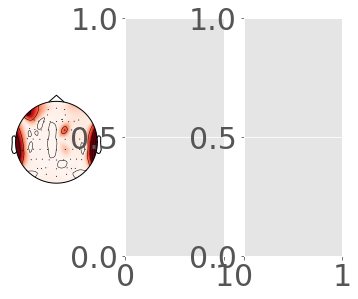

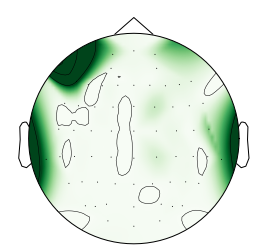

(<matplotlib.image.AxesImage at 0x7f9c97a3dad0>,
 <matplotlib.contour.QuadContourSet at 0x7f9c97a3e290>)

In [269]:
fig, axes = plt.subplots(1,3)


mne.viz.plot_topomap(bps[0], info, axes=axes[0], cmap=cmaps[0])
mne.viz.plot_topomap(bps[1], info, cmap=cmaps[1])